# Generate Masks on Challenge Data

> We only filter for Hurricane Data

* After completing the EDA, we use this notebook / pipeline to preview and generate masks for the computer vision model to detect damaged buildings, as well as the classes of damage. 
* In the context of image processing and computer vision, a `mask` is a binary or multi-class image that outlines or highlights specific parts of another image.
* While the dataset should include both the original images and the corresponding masks, we also focus on generating a comprehensive set of accurate masks.

In [1]:
# ignore warning messages
import warnings

warnings.filterwarnings("ignore")

# for data processing
import pandas as pd
import numpy as np
import json
from shapely import wkt
from shapely.geometry import Polygon

# for image processing & viz
import cv2
import skimage
from PIL import Image, ImageDraw, ImageColor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# for getting random samples from data
from random import randint

# for creating and managing directories locally
import os

# for progress bars
from tqdm.autonotebook import tqdm

# for fast I/O of image files
from concurrent.futures import ThreadPoolExecutor

In [2]:
pd.set_option("display.max_columns", None)

## Notebook Params

Based on toggling these variables, the notebook performs additional tasks when all cells are run, else these are skipped.

* `SAVE_OVERLAY`: Adds polygons to satellite images with damage class labels, and then saves to disk for all images (~10 mins)
* `SAVE_MASKS`: Similar to overlay, but is more computer-readable and generates masks for the ML model

In [3]:
SAVE_OVERLAY: bool = False
SAVE_MASKS: bool = False

### Read Data

* We read in the images data, where each row corresponds to a pre image or post image.
* We also read in the buildings data, where each row corresponds to a building (containing the geometry of the building on the image as a polygon)

We join the building data into image, so that we have an image-level dataset that contains a list of polygons to plot all buildings at once on the image

In [4]:
MAIN_DATA_DIR: str = "/home/jupyter-jhub-admin/data/xview2"
CHALLENGE_DATA_DIR: str = MAIN_DATA_DIR + "/challenge"
PROCESSED_DATA_DIR: str = MAIN_DATA_DIR + "/processed"

print(f"{CHALLENGE_DATA_DIR=}")
print(f"{PROCESSED_DATA_DIR=}")

CHALLENGE_DATA_DIR='/home/jupyter-jhub-admin/data/xview2/challenge'
PROCESSED_DATA_DIR='/home/jupyter-jhub-admin/data/xview2/processed'


In [5]:
img_meta_df = pd.read_parquet(f"{PROCESSED_DATA_DIR}/images.parquet")

# Declaring Image path
img_meta_df["image_path"] = (
    CHALLENGE_DATA_DIR
    + "/"
    + img_meta_df["dataset"]
    + "/images/"
    + img_meta_df["img_name"]
)

# Filtering only hurricane disasters in scope of this project
img_meta_df = img_meta_df[img_meta_df["disaster_sub_type"] == "hurricane"]

print(img_meta_df.shape)
print(img_meta_df.iloc[0]["image_path"])
img_meta_df.head()

(4046, 24)
/home/jupyter-jhub-admin/data/xview2/challenge/hold/images/hurricane-matthew_00000012_pre_disaster.png


,capture_date,gsd,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,disaster_type,disaster_sub_type,width,height,dataset,image_id,is_pre_image,img_name,id,building_count,no_damage_buildings,minor_damage_buildings,major_damage_buildings,destroyed_buildings,unclassified_buildings,image_path
0,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...
1,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000015,True,hurricane-matthew_00000015_pre_disaster.png,MjU4MzkzNQ.eGkpU6lYXd1co5g1a8Kqa0GnF_M,3,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...
2,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000020,True,hurricane-matthew_00000020_pre_disaster.png,MjU4Mzk2Mw.qyhEB0t3wday68p_qqZuIJ0LBbs,86,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...
3,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000024,True,hurricane-matthew_00000024_pre_disaster.png,MjU4Mzk4Mg.xwQHzF2LEQxSVC3oi7-Dm-UvlSc,333,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...
4,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000025,True,hurricane-matthew_00000025_pre_disaster.png,MjU4Mzk4NQ.RsNC-j-lQcImj6XqruNjCofqYJw,34,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...


In [6]:
buildings_df = pd.read_parquet(f"{PROCESSED_DATA_DIR}/buildings.parquet")

print(buildings_df.shape)
buildings_df.head()

(272908, 12)


,disaster,disaster_type,disaster_sub_type,id,image_id,img_name,building_id,map_polygon,image_polygon,feature_type,damage,dataset
0,guatemala-volcano,volcano,volcano,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003,guatemala-volcano_00000003_post_disaster.png,88703461-a33d-4327-9244-a0d4e2242ede,POLYGON ((-90.83554484998086 14.43845885230631...,"POLYGON ((452.9629646916362 86.81005767060303,...",building,minor-damage,test
1,guatemala-volcano,volcano,volcano,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003,guatemala-volcano_00000003_post_disaster.png,e168e405-3479-44ee-849a-7af2ed32dee1,POLYGON ((-90.83658244456636 14.43748886352666...,"POLYGON ((226.8267143191367 307.8635026276182,...",building,destroyed,test
2,guatemala-volcano,volcano,volcano,MjU0NzE2Nw.m-DFlxQeMVNP1AiBYflHzPY-lgA,guatemala-volcano_00000003,guatemala-volcano_00000003_post_disaster.png,9f8f8916-b6c5-4fa8-ab64-c8fd86eca035,POLYGON ((-90.83487803042956 14.43776515972186...,"POLYGON ((601.0923397346356 241.9779197994199,...",building,minor-damage,test
3,hurricane-florence,flooding,hurricane,MjU0NjYxOA.oDPPzoZ4qHe2KBGmwerMXsQbF9I,hurricane-florence_00000005,hurricane-florence_00000005_post_disaster.png,624f417b-fd9f-4544-ba25-9ba2be361d27,POLYGON ((-79.05237408501472 33.58644838741007...,POLYGON ((43.56144524808627 0.0045224975870225...,building,no-damage,test
4,hurricane-florence,flooding,hurricane,MjU0NjYxOA.oDPPzoZ4qHe2KBGmwerMXsQbF9I,hurricane-florence_00000005,hurricane-florence_00000005_post_disaster.png,557fbd1d-68bf-4776-a1a5-9bbd45cda227,POLYGON ((-79.05057793741786 33.58642007435035...,POLYGON ((406.9497321265795 0.0095005985733089...,building,no-damage,test


In [7]:
img_building_df: pd.DataFrame = img_meta_df.merge(
    buildings_df.drop(
        columns=[
            c
            for c in buildings_df.columns
            if c in img_meta_df.columns and c != "image_id"
        ],
    ),
    "left",
    "image_id",
)

print(img_building_df.shape)
img_building_df.head()

(218132, 29)


,capture_date,gsd,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,disaster,disaster_type,disaster_sub_type,width,height,dataset,image_id,is_pre_image,img_name,id,building_count,no_damage_buildings,minor_damage_buildings,major_damage_buildings,destroyed_buildings,unclassified_buildings,image_path,building_id,map_polygon,image_polygon,feature_type,damage
0,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...,ba98856e-9d07-41d1-8a0b-df43e3b700e6,POLYGON ((-73.74876670508114 18.23314387348863...,"POLYGON ((962.5830311402426 732.6440672732887,...",building,minor-damage
1,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...,faaf8065-e7fd-4aed-bbbb-28ff2df52c25,POLYGON ((-73.74927438612076 18.23405043614472...,"POLYGON ((850.6483179334692 526.8602300314485,...",building,minor-damage
2,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...,75ea79c9-7a31-4794-83be-faaa51e652ef,POLYGON ((-73.74954942051457 18.23455000526948...,"POLYGON ((789.9954070036398 413.4541411046255,...",building,minor-damage
3,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...,c37a1fb9-28ac-4630-b830-1fd213a2ba83,POLYGON ((-73.75020061206322 18.23495699426978...,"POLYGON ((647.5971193420658 321.6993047127825,...",building,minor-damage
4,2013-01-05 16:02:21+00:00,1.911686,10.824036,0.476713,160.20961,46.697117,135.871735,hurricane-matthew,wind,hurricane,1024,1024,hold,hurricane-matthew_00000012,True,hurricane-matthew_00000012_pre_disaster.png,MjU4Mzg2MQ.JfDmqG5_JxvoozHC_uqvD96VaWo,108,0,0,0,0,0,/home/jupyter-jhub-admin/data/xview2/challenge...,504f4680-7cc0-4ad1-b5c9-2c917a308c9b,POLYGON ((-73.74908907387508 18.23460160661307...,"POLYGON ((890.1331975119865 401.0133550977981,...",building,minor-damage


#### Creating Pre-and-Post Polygon Overlaid Images

* **Pre-Image Analysis**: The pre-disaster images (and their corresponding masks) serve as a baseline, showing the condition of buildings and infrastructure before the event. This helps the model understand what "undamaged" structures look like.

* **Post-Image Analysis**: The post-disaster images (and their corresponding masks) reveal the aftermath of the disaster. By comparing these with the pre-disaster baseline, the model can identify changes, damages, and anomalies.

This information is crucial for the model to recognize what constitutes damage or alteration in the post-images

In the following cell, we create a meta-dataframe that has the following attributes:

* Each row represents a distinct pre or post image
* Each row contains a column with a list of polygons, and a column with a list of damage classifications.
* The index of the polygon in a row has the equivalent index of `damage` for that same row. (both columns contain list (array) values)
* The `building_count` represents the size of both arrays for that row (since we have one polygon per building, and its equivalent damage classification)

In [8]:
# Aggregate polygons by image_id
img_geometries_df = (
    img_building_df.groupby(["image_id", "image_path", "is_pre_image"])
    .agg(
        {
            "dataset": "first",
            "building_id": "nunique",
            "width": "first",
            "height": "first",
            "image_polygon": lambda x: list(x),
            "damage": lambda x: list(x),
        }
    )
    .rename(
        columns={
            "building_id": "building_count",
            "image_polygon": "building_geometries",
        }
    )
    .reset_index()
)

for col_name in ["building_geometries", "damage"]:
    img_geometries_df[col_name] = img_geometries_df[col_name].apply(
        lambda cell: [c for c in cell if c]
    )

img_geometries_df["building_geometries"] = img_geometries_df[
    "building_geometries"
].apply(lambda cell: [wkt.loads(c) for c in cell])

print(img_geometries_df.shape)
img_geometries_df.head()

(4046, 9)


,image_id,image_path,is_pre_image,dataset,building_count,width,height,building_geometries,damage
0,hurricane-florence_00000000,/home/jupyter-jhub-admin/data/xview2/challenge...,False,train,110,1024,1024,[POLYGON ((126.2051261436394 0.006184273110124...,"[no-damage, no-damage, no-damage, no-damage, n..."
1,hurricane-florence_00000000,/home/jupyter-jhub-admin/data/xview2/challenge...,True,train,110,1024,1024,[POLYGON ((126.2051261436394 0.006184273110124...,"[no-damage, no-damage, no-damage, no-damage, n..."
2,hurricane-florence_00000001,/home/jupyter-jhub-admin/data/xview2/challenge...,False,train,91,1024,1024,[POLYGON ((404.8428229479346 1022.985470946143...,"[no-damage, no-damage, no-damage, no-damage, n..."
3,hurricane-florence_00000001,/home/jupyter-jhub-admin/data/xview2/challenge...,True,train,91,1024,1024,[POLYGON ((404.8428229479346 1022.985470946143...,"[no-damage, no-damage, no-damage, no-damage, n..."
4,hurricane-florence_00000002,/home/jupyter-jhub-admin/data/xview2/challenge...,False,train,6,1024,1024,[POLYGON ((6.826987571875607 544.8866551972654...,"[no-damage, no-damage, no-damage, no-damage, n..."


Simple Data Quality Check to Ensure that all buildings per image have been retrieved for masking

In [9]:
# Check if polygon counts match up with building counts from metadata
assert (
    img_geometries_df[
        img_geometries_df["building_geometries"].str.len()
        != img_geometries_df["building_count"]
    ].shape[0]
    == 0
)

# Check if damage counts match up with building counts from metadata
assert (
    img_geometries_df[
        img_geometries_df["damage"].str.len() != img_geometries_df["building_count"]
    ].shape[0]
    == 0
)

assert sorted(list(img_geometries_df["dataset"].unique())) == [
    "hold",
    "test",
    "train",
], "One or more datasets not present in input"

### Declare Function to Preview Images with Building Outlines

* This function takes in the location of an image, the list of polygons (building geometries) to plot, as well as their respective damage classes.
* The polygons and building damage classes are provided as two lists, and the indexes of each list are used to map buildings to their damage type
* It is essential for `polygons` list to be a list of `shapely.geometryy.Polygon` objects, as some shapely functions are used.
* A color-code map is declared to show different buildings with various damage classes with different colored borders.

In [10]:
# Color map for classes
color_map = {
    "no-damage": "white",
    "minor-damage": "yellow",
    "major-damage": "orange",
    "destroyed": "red",
    "unclassified": "grey",
}

In [11]:
def add_polygons_to_ax(ax, image, polygons: list[Polygon], classes: list[str]):
    ax.imshow(image)
    for polygon, class_name in zip(polygons, classes):
        color = color_map.get(class_name, "grey")
        exterior = polygon.exterior.coords.xy
        patch = patches.Polygon(
            xy=list(zip(exterior[0], exterior[1])),
            closed=True,
            edgecolor=color,
            fill=False,
        )
        ax.add_patch(patch)
    return ax


def plot_images_with_polygons(image_uri: str, polygons: list[str], classes: list[str]):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    pre_image = skimage.io.imread(image_uri)
    post_image = skimage.io.imread(image_uri.replace("_pre_", "_post_"))
    ax[0] = add_polygons_to_ax(ax[0], pre_image, polygons, classes)
    ax[1].imshow(post_image)
    ax[0].set_title("Pre-Image with Labels")
    ax[1].set_title("Post-Image no Labels")
    plt.tight_layout()
    plt.show()

### Preview Buildings on Image

The cell belows allows us to see different images, overlaid with buildings outlines color coded by damage. 

* If `sample_img` parameter is not set, it finds and displays a random pre-and-post image from the dataset, with the pre-image labeled with geometries
* If `sample_img` is labeled with an `image_id`, then that image is shown 

188
/home/jupyter-jhub-admin/data/xview2/challenge/train/images/hurricane-florence_00000188_pre_disaster.png


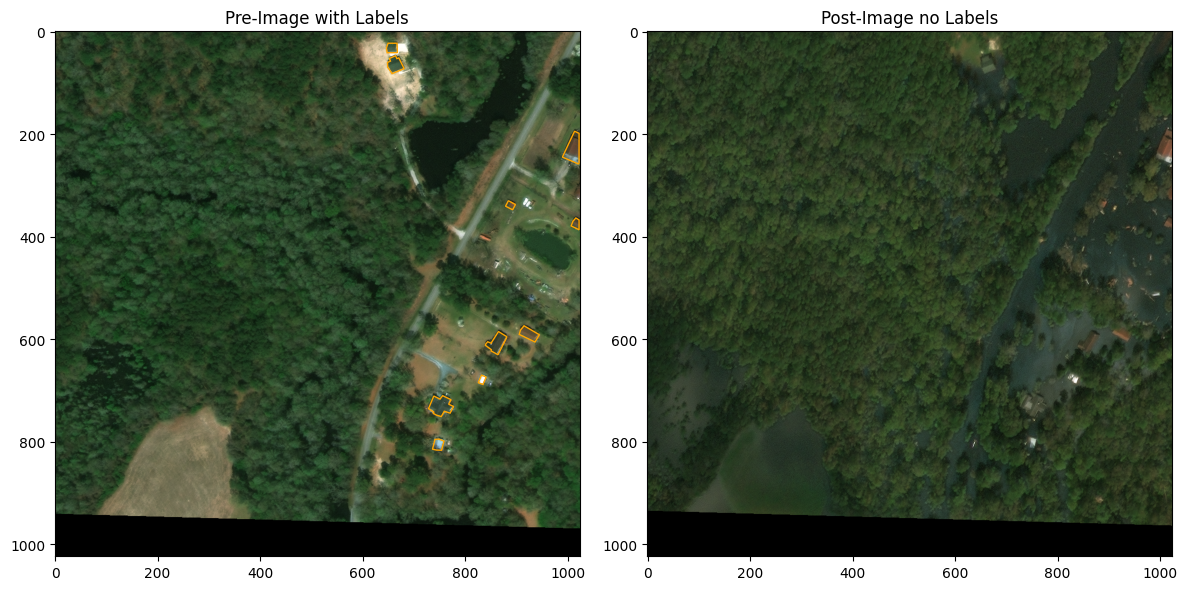

In [28]:
unique_img_geometries = img_geometries_df[
    img_geometries_df["is_pre_image"] == True
].reset_index(drop=True)

# Leave this parameter empty to choose a random image. Fill it with an image ID to see masks for that image.
sample_img: str = "hurricane-florence_00000188"
# sample_img: str = ""

random_sample: int = (
    randint(0, len(unique_img_geometries))
    if not sample_img
    else unique_img_geometries[unique_img_geometries["image_id"] == sample_img].index[0]
)
print(random_sample)
print(unique_img_geometries.iloc[random_sample]["image_path"])


plot_images_with_polygons(
    unique_img_geometries.iloc[random_sample]["image_path"],
    unique_img_geometries.iloc[random_sample]["building_geometries"],
    unique_img_geometries.iloc[random_sample]["damage"],
)

#### Samples of Interest

* `hurricane-matthew_00000089` - very many minor damaged buildings
* `hurricane-harvey_00000006` - minor damage shown but nothing evident from image
* `hurricane-michael_00000107` - clear highly damaged buildings
* `hurricane-michael_00000461` - cars
* `hurricane-matthew_00000369` - cloud + river skewed
* `hurricane-florence_00000188` - buildings flooded

## Save Polygon Overlaid Images

In order to aid exploration of data, we save all pre-and-post images from the train, test and holdout datasets into their own directory. Each image will have the underlying satellite image with the polygons overlaid on top so that we can directly visualize polygons on the satellite images. 

> We define an key `overlay` directory 

#### Create Output Directories

In [13]:
OVERLAY_DIR: str = f"{MAIN_DATA_DIR}/overlay"
os.makedirs(OVERLAY_DIR, exist_ok=True)
OVERLAY_DIR

'/home/jupyter-jhub-admin/data/xview2/overlay'

In [14]:
for d in ["train", "test", "hold"]:
    os.makedirs(f"{OVERLAY_DIR}/{d}/images", exist_ok=True)

#### Declare Function to Embed Polygons on Image and Save as New Image

In [15]:
def save_image_with_polygons(
    image_uri: str, polygons: list[Polygon], classes: list[str], output_path: str
):
    image = Image.open(image_uri)
    drawable_image = ImageDraw.Draw(image)

    for polygon, class_name in zip(polygons, classes):
        # Default to grey
        color = color_map.get(class_name, (128, 128, 128))
        # Assuming the polygon is simple and can be drawn with a list of (x, y) tuples
        exterior_coords = list(polygon.exterior.coords)
        drawable_image.polygon(exterior_coords, outline=color)

    image.save(output_path)

Creates a `list[dict]` representation of the dataframe to pass for threading I/O

In [16]:
img_geometries_dict: list[dict] = img_geometries_df.to_dict(orient="records")
assert len(img_geometries_dict) == img_geometries_df.shape[0]
print(type(img_geometries_dict))
img_geometries_dict[0].keys()

<class 'list'>


dict_keys(['image_id', 'image_path', 'is_pre_image', 'dataset', 'building_count', 'width', 'height', 'building_geometries', 'damage'])

Declare a thread-safe function to use the input attributes, create overlay image and save to new output destination

In [17]:
def save_overlay_image_threaded(x: dict):
    image_type: str = "pre" if x["is_pre_image"] is True else "post"
    output_path = (
        OVERLAY_DIR
        + f"/{x['dataset']}"
        + "/images/"
        + x["image_id"]
        + f"_{image_type}_disaster.png"
    )
    save_image_with_polygons(
        image_uri=x["image_path"],
        polygons=x["building_geometries"],
        classes=x["damage"],
        output_path=output_path,
    )
    pbar.update(1)

#### Concurrent I/O & Saving

⚠️ **This cell may take about 10 minutes to save all thousands of overlaid images**. 

We use `ThreadPoolExecutor` to save the images concurrently to disk. This will be significantly faster at writing images to disk. This is also a natural fit since I/O tasks like reading and writing images.

In [18]:
if SAVE_OVERLAY:
    pbar = tqdm(total=len(img_geometries_dict), leave=False, position=0)
    
    with ThreadPoolExecutor(max_workers=20) as executor:
        executor.map(save_overlay_image_threaded, img_geometries_dict)
else:
    print("Skipping Overlay Save to Disk Step")

Skipping Overlay Save to Disk Step


## Generate & Save Masks

The overlaid polygons are human readable, but we need to perform an additional step for the computer system to read and process polygon overlaid image data using masks. 

In [19]:
def display_image_with_mask(image_uri: str, polygons: list[Polygon], classes: list[str]):
    # Read the image
    image = skimage.io.imread(image_uri)
    mask = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

    # Prepare an Image object for drawing
    mask_image = Image.fromarray(mask)
    drawable_mask = ImageDraw.Draw(mask_image)

    for polygon, class_name in zip(polygons, classes):
        color = color_map.get(class_name, "grey")
        # Convert color to RGB if needed
        if isinstance(color, str):
            color = ImageColor.getrgb(color)

        exterior_coords = list(polygon.exterior.coords)
        drawable_mask.polygon(exterior_coords, fill=color)

    # Convert mask back to numpy array for display
    mask = np.array(mask_image)

    # Create figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title("Pre-Image No Labels")
    ax[1].imshow(mask)
    ax[1].set_title("Pre-Image Masks")

    for a in ax:
        a.axis('off')  # Hide axes

    plt.tight_layout()
    plt.show()

1157
/home/jupyter-jhub-admin/data/xview2/challenge/train/images/hurricane-matthew_00000089_pre_disaster.png


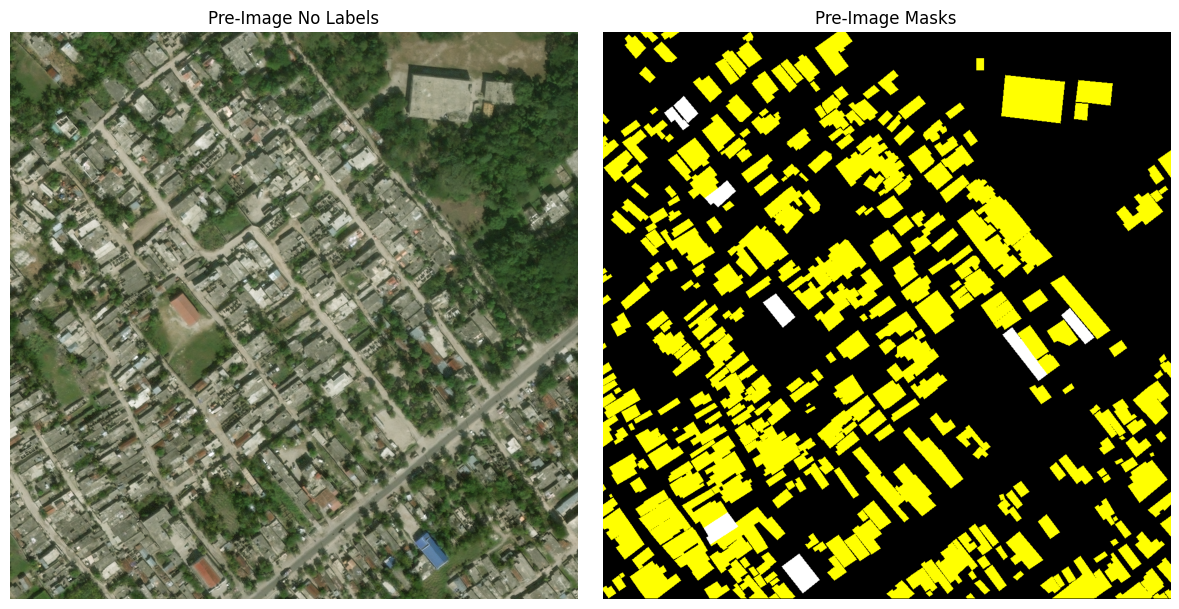

In [20]:
unique_img_geometries = img_geometries_df[
    img_geometries_df["is_pre_image"] == True
].reset_index(drop=True)

# Leave this parameter empty to choose a random image. Fill it with an image ID to see masks for that image.
sample_img: str = "hurricane-matthew_00000089"
# sample_img: str = ""

random_sample: int = (
    randint(0, len(unique_img_geometries))
    if not sample_img
    else unique_img_geometries[unique_img_geometries["image_id"] == sample_img].index[0]
)
print(random_sample)
print(unique_img_geometries.iloc[random_sample]["image_path"])


display_image_with_mask(
    unique_img_geometries.iloc[random_sample]["image_path"],
    unique_img_geometries.iloc[random_sample]["building_geometries"],
    unique_img_geometries.iloc[random_sample]["damage"],
)

## Save Polygon Masked Images

Here we define one image pair as having a mask. Each image contains the masks of the polygons.

> We define an key `masks` directory 

#### Create Output Directories

In [21]:
MASK_DIR: str = f"{MAIN_DATA_DIR}/masks"
os.makedirs(MASK_DIR, exist_ok=True)
MASK_DIR

'/home/jupyter-jhub-admin/data/xview2/masks'

In [22]:
for d in ["train", "test", "hold"]:
    os.makedirs(f"{MASK_DIR}/{d}/images", exist_ok=True)

In [23]:
ImageColor.getrgb("orange")

(255, 165, 0)

#### Declare Function to Create Masks When Given an Input Image with Polygons

In [24]:
def save_mask_with_polygons(image_uri: str, polygons: list[Polygon], classes: list[str], output_path: str) -> None:
    # Determine the size of the mask from the original image
    original_image = Image.open(image_uri)
    mask = np.zeros((original_image.height, original_image.width, 3), dtype=np.uint8)

    # Prepare an Image object for the mask
    mask_image = Image.fromarray(mask)
    drawable_mask = ImageDraw.Draw(mask_image)

    for polygon, class_name in zip(polygons, classes):
        color = color_map.get(class_name, "grey")
        # Ensure color is in RGB
        if isinstance(color, str):
            color = ImageColor.getrgb(color)

        exterior_coords = list(polygon.exterior.coords)
        drawable_mask.polygon(exterior_coords, fill=color)

    # Save the mask image
    mask_image.save(output_path)

The function below tries to decipher the output path, creates a mask and saves it in a thread-safe manner.

In [25]:
def save_mask_image_threaded(x: dict):
    output_path = (
        MASK_DIR
        + f"/{x['dataset']}"
        + "/images/"
        + x["image_id"]
        + ".png"
    )
    save_mask_with_polygons(
        image_uri=x["image_path"],
        polygons=x["building_geometries"],
        classes=x["damage"],
        output_path=output_path,
    )
    pbar.update(1)

Creates a `list[dict]` representation of the dataframe to pass for threading I/O

> Note that since we need one mask per pair of pre-and-post images, instead of one per image - we take distinct pre-images with their polygons for masking

In [26]:
img_masks_dict: list[dict] = unique_img_geometries.to_dict(orient="records")
assert len(img_masks_dict) == unique_img_geometries.shape[0]
print(len(img_masks_dict))
print(type(img_masks_dict))
img_masks_dict[0].keys()

2023
<class 'list'>


dict_keys(['image_id', 'image_path', 'is_pre_image', 'dataset', 'building_count', 'width', 'height', 'building_geometries', 'damage'])

#### Concurrent I/O & Saving

⚠️ **This cell may take about 1 minutes to save all thousands of masked images**. 

We use `ThreadPoolExecutor` to save the images concurrently to disk. This will be significantly faster at writing images to disk. This is also a natural fit since I/O tasks like reading and writing images.

In [27]:
if SAVE_MASKS:
    pbar = tqdm(total=len(img_masks_dict), leave=False, position=0)
    
    with ThreadPoolExecutor(max_workers=20) as executor:
        executor.map(save_mask_image_threaded, img_masks_dict)
else:
    print("Skipping Mask Save to Disk Step")

Skipping Mask Save to Disk Step
